In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from scipy.spatial.transform import Rotation as R
import pandas as pd
import json
from tqdm import tqdm
import random
import mujoco
import pickle

MODEL_DIR = "/common/home/dm1487/robotics_research/ktamp/ml4kp_ktamp/resources/models/custom_walled_envs/jun22/random_start_random_goal_single_obstacle_room_2_200k_halfrad"

In [6]:
def get_geom_sizes(config_name):
    model = mujoco.MjModel.from_xml_path(f"{MODEL_DIR}/{config_name}.xml")
    # Get all geom information
    geom_sizes = {}
    for i in range(model.ngeom):
        # Get geom name
        geom_name = mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_GEOM, i)
        if geom_name is None:
            geom_name = f"geom_{i}"
        geom_sizes[geom_name] = model.geom_size[i]
    
    del model
    return geom_sizes

create_rectange = lambda x, y, angle, w, h, color, alpha=1: Rectangle((x-w, y-h), w*2, h*2, angle=angle*180/np.pi, fill=True, color=color, rotation_point='center', alpha=alpha)
create_circle = lambda x, y, r, color, alpha=1: Circle((x, y), r, color=color, alpha=alpha)

DATA_DIR = "/common/users/dm1487/namo_data/jul5/random_start_random_goal_single_obstacle_room_2_200k" # jul3/random_start_random_goal_single_obstacle_room_2_200k"

datafiles = [os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) if f.endswith(".json") and "final_state" in f]

In [3]:
from collections import Counter
dp_counts = []
env_counts = []
for datafile in tqdm(datafiles):
    try:
        with open(datafile, "r") as f:
            tmp_data = json.load(f)
        if len(tmp_data['data_points']) == 1:
            if "action" not in tmp_data['data_points'][0]:
                continue
        dp_counts.append(len(tmp_data['data_points'])-1)
        env_counts.append(tmp_data['config_name'])
    except Exception as e:
        print(e)
        continue
counts = Counter(dp_counts)
env_counts = Counter(env_counts)

  0%|          | 20/74791 [00:00<14:47, 84.25it/s]

 35%|███▌      | 26488/74791 [04:42<08:34, 93.86it/s] 


KeyboardInterrupt: 

In [4]:
env_list_vis = sorted(env_counts.keys(), key=lambda x: int(x.split("_")[-1]), reverse=True)
select_datafiles = [datafile for datafile in datafiles if any(env_name in datafile for env_name in env_list_vis)]
print(len(env_list_vis), len(select_datafiles))

40 1482


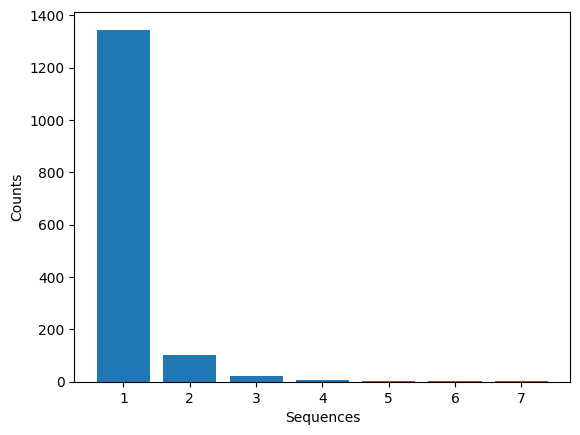

In [5]:
# Method 2: With explicit positioning and labels
categories = list(counts.keys())
values = list(counts.values())

plt.bar(categories, values)
plt.xticks(categories)  # Ensure all categories are shown
plt.xlabel("Sequences")
plt.ylabel("Counts")
# plt.title("")
plt.show()

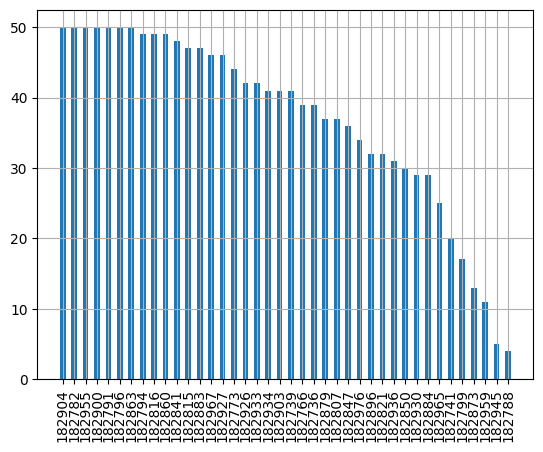

In [6]:
sorted(env_counts.items(), key=lambda x: x[1], reverse=True)
env_names = []
env_ctrs = []
for env_name, env_count in sorted(env_counts.items(), key=lambda x: x[1], reverse=True):
    # if env_count < 4:
    #     print(env_name, env_count)
    if env_name in env_list_vis:
        env_names.append(env_name.split("_")[-1])
        env_ctrs.append(env_count)
    
plt.bar(env_names, env_ctrs, width=0.5)
plt.xticks(rotation=90)
plt.grid()

In [7]:
# Split environments into easy, medium, hard based on their counts

easy_envs = [env for env, count in env_counts.items() if 40 <= count <= 50]
medium_envs = [env for env, count in env_counts.items() if 20 <= count < 40]
hard_envs = [env for env, count in env_counts.items() if 0 <= count < 20]

print(len(easy_envs), easy_envs)
print(len(medium_envs), medium_envs)
print(len(hard_envs), hard_envs)

easy_envs_datafiles = [datafile for datafile in datafiles if any(env_name in datafile for env_name in easy_envs)]
medium_envs_datafiles = [datafile for datafile in datafiles if any(env_name in datafile for env_name in medium_envs)]
hard_envs_datafiles = [datafile for datafile in datafiles if any(env_name in datafile for env_name in hard_envs)]

print(len(easy_envs_datafiles))
print(len(medium_envs_datafiles))
print(len(hard_envs_datafiles))


21 ['env_config_182926', 'env_config_182967', 'env_config_182904', 'env_config_182794', 'env_config_182934', 'env_config_182815', 'env_config_182782', 'env_config_182955', 'env_config_182900', 'env_config_182841', 'env_config_182791', 'env_config_182883', 'env_config_182816', 'env_config_182796', 'env_config_182773', 'env_config_182860', 'env_config_182903', 'env_config_182927', 'env_config_182863', 'env_config_182739', 'env_config_182933']
14 ['env_config_182965', 'env_config_182936', 'env_config_182741', 'env_config_182896', 'env_config_182879', 'env_config_182821', 'env_config_182766', 'env_config_182930', 'env_config_182976', 'env_config_182884', 'env_config_182847', 'env_config_182807', 'env_config_182850', 'env_config_182736']
5 ['env_config_182959', 'env_config_182799', 'env_config_182788', 'env_config_182873', 'env_config_182945']
982
450
50


In [ ]:
random.shuffle(select_datafiles)
dp_counts = {}
# for datafile in datafiles[:1]:
print(select_datafiles)
for datafile in select_datafiles:
    with open(datafile, "r") as f:
        data = json.load(f)
        break
config_name = data['config_name']
data_points = data['data_points']

geom_sizes = get_geom_sizes(data['config_name'])
print(config_name, geom_sizes)
fig, ax = plt.subplots(1, len(data_points), figsize=(20, 10))
for idx, dp in enumerate(data['data_points']):
    
    for objects, info in dp['state']['objects'].items():
        if objects in geom_sizes:
            color = 'red'
            if "movable" in objects:
                color = 'yellow'
            rect_patch = create_rectange(*info['position'][:2], R.from_quat(info['quaternion'], scalar_first=True).as_euler('xyz')[-1], *geom_sizes[objects][:2], color)
            ax[idx].add_patch(rect_patch)
        
    if "action" in dp:
        print(dp['action']['which_state'])
        if dp['action']['which_state'] == "final":
            print(dp['action'])
            object_name = dp['action']["object_name"]
            d = dp['action']["final_state"]
            rect_patch = create_rectange(*d['position'][:2], R.from_quat(d['quaternion'], scalar_first=True).as_euler('xyz')[-1], *geom_sizes[object_name][:2], 'green', alpha=0.2)
            ax[idx].add_patch(rect_patch)
        else:
            object_name = dp['action']["object_name"]
            d = dp['action']["goal_state"]
            rect_patch = create_rectange(*d['position'][:2], R.from_quat(d['quaternion'], scalar_first=True).as_euler('xyz')[-1], *geom_sizes[object_name][:2], 'blue', alpha=0.2)
            ax[idx].add_patch(rect_patch)
            
            
    # if idx < len(data['data_points']) - 1: 
    #     print(len(data["control_sequence"][idx]))
    #     for control_seq in data["control_sequence"][idx][::25]:
            
    #         ax[idx].scatter(control_seq['position'][0], control_seq['position'][1], color='black', s=10)
            
    circle_patch = create_circle(*dp['state']['robot']['position'][:2], 0.15, 'blue')
    ax[idx].add_patch(circle_patch)

    circle_patch = create_circle(*data['robot_goal'], 0.25, 'green')
    
    ax[idx].add_patch(circle_patch)
    
    ax[idx].set_xlim(-2.1, 2.1)
    ax[idx].set_ylim(-3.1, 3.1)

In [ ]:
categories = {
    "easy": [],
    "medium": [],
    "hard": []
}
for cat_name in categories.keys():
    if cat_name == "easy":
        lower, upper = 20, 30
    elif cat_name == "medium":
        lower, upper = 10, 20
    elif cat_name == "hard":
        lower, upper = 0, 10
    config_names =[(env_names, env_counts) for env_names, env_counts in env_counts.items() if (env_counts <= upper and env_counts > lower)]
    categories[cat_name] = config_names

samples = {}
for cat_name in categories.keys():
    samples[cat_name] = random.sample(categories[cat_name], 5)
    print(samples[cat_name])

# with open("samples.json", "w") as f:
#     json.dump(samples, f)
print(samples)

In [ ]:
# random.shuffle(datafiles)
dp_counts = {}
# for datafile in datafiles[:1]:

config_name = random.choice(config_names) + '_'
# config_name = 'env_config_183583_'
drawn = False
geom_sizes = get_geom_sizes(config_name[:-1])
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

min_dp = np.inf
for datafile in datafiles:
    if config_name not in datafile:
        continue
    with open(datafile, "r") as f:
        data = json.load(f)
    if len(data['data_points']) < min_dp:
        min_dp = len(data['data_points'])
        min_datafile = datafile


for datafile in datafiles:
    if config_name not in datafile:
        continue
    with open(datafile, "r") as f:
        data = json.load(f)
    data_points = data['data_points']
    
    print(len(data['data_points']), min_dp)
    
    if len(data['data_points']) != min_dp:
        continue

    for idx, dp in enumerate(data['data_points']):
        
        if not drawn:
            for objects, info in dp['state']['objects'].items():
                if objects in geom_sizes:
                    color = 'red'
                    if "movable" in objects:
                        color = 'yellow'
                    rect_patch = create_rectange(*info['position'][:2], R.from_quat(info['quaternion'], scalar_first=True).as_euler('xyz')[-1], *geom_sizes[objects][:2], color)
                    ax[idx].add_patch(rect_patch)
            drawn = True
                
        if idx < len(data['data_points']) - 1: 
            # print(len(data["control_sequence"][idx]))

            for control_seq in data["control_sequence"][idx][::25]:
                ax[idx].scatter(control_seq['position'][0], control_seq['position'][1], color='black', s=10)
                
        circle_patch = create_circle(*dp['state']['robot']['position'][:2], 0.15, 'blue')
        ax[idx].add_patch(circle_patch)
    

        circle_patch = create_circle(*data['robot_goal'], 0.25, 'green')
        ax[idx].add_patch(circle_patch)
        ax[idx].set_xlim(-3.1, 3.1)
        ax[idx].set_ylim(-3.1, 3.1)
        break

In [ ]:
# for datafile in datafiles[:1]:
#     print(datafile)
#     with open(datafile, "r") as f:
#         data = json.load(f)
data["control_sequence"][0][1]

## Extracting the best of the data files

In [40]:
from_file = False

if from_file:
    with open('/common/users/dm1487/namo_data/may5_random_start_random_goal_many_env.pkl', 'rb') as f:
        final_datafiles = pickle.load(f)
else:
    by_config_name = {}
    for datafile in tqdm(datafiles):
        config_name = "env_config_" + datafile.split('env_config_')[-1].split('_')[0]
        if config_name not in by_config_name:
            by_config_name[config_name] = [500]
        with open(datafile, "r") as f:
            data = json.load(f)
        if len(data['data_points']) < by_config_name[config_name][0]:
            by_config_name[config_name] = [len(data['data_points']), datafile]
        elif len(data['data_points']) == by_config_name[config_name][0]:
            by_config_name[config_name].append(datafile)
        
    final_datafiles = []
    for by_config_name_vals in by_config_name.values():
        final_datafiles.extend(by_config_name_vals[1:3])


100%|██████████| 56923/56923 [00:25<00:00, 2270.11it/s]


In [41]:
import pickle
with open('/common/users/dm1487/namo_data/jul5_random_start_random_goal_many_env_small.pkl', 'wb') as f:
     pickle.dump(final_datafiles, f)

In [42]:
len(final_datafiles)

28612

In [ ]:
random.shuffle(final_datafiles)
dp_counts = {}
for datafile in [files for files in final_datafiles if "env_config_1342_" in files]:
    print(datafile)
    with open(datafile, "r") as f:
        data = json.load(f)
    if len(data['data_points']) > 2:
        break
config_name = data['config_name']
data_points = data['data_points']

geom_sizes = get_geom_sizes(data['config_name'])
fig, ax = plt.subplots(1, len(data_points), figsize=(20, 4))
for idx, dp in enumerate(data['data_points']):
    for objects, info in dp['state']['objects'].items():
        if objects in geom_sizes:
            rect_patch = create_rectange(*info['position'][:2], R.from_quat(info['quaternion'], scalar_first=True).as_euler('xyz')[-1], *geom_sizes[objects][:2], 'yellow')
            ax[idx].add_patch(rect_patch)
            
    circle_patch = create_circle(*dp['state']['robot']['position'][:2], 0.15, 'blue')
    ax[idx].add_patch(circle_patch)
    circle_patch = create_circle(*data['robot_goal'], 0.25, 'green')
    ax[idx].add_patch(circle_patch)
    ax[idx].set_xlim(-2.95, 2.95)
    ax[idx].set_ylim(-2.95, 2.95)
plt.show()

In [ ]:
dp_counts = []
for datafile in tqdm(final_datafiles):
    with open(datafile, "r") as f:
        data = json.load(f)
    dp_counts.append(len(data['data_points']))

In [ ]:
from collections import Counter
subgoal_counts = 0
final_goal_counts = 0
for key, value in Counter(dp_counts).items():
    if key > 2 and key < 11:
        final_goal_counts += value
        subgoal_counts += (key - 2) * value
subgoal_counts, final_goal_counts, subgoal_counts + final_goal_counts

In [ ]:
img_data = "/common/users/dm1487/namo_data/images/jun6/random_start_random_goal_many_env"
img_files = [f for f in os.listdir(img_data) if f.endswith('.npz')]
img_file = random.sample(img_files, 1)[0]

data = np.load(os.path.join(img_data, img_file))
print(data.keys())
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
sec = np.zeros_like(data['scene'])
sec[:, :, 1:2] = data['object_mask']
sec[:, :, 2:3] = data['goal_mask']
third = np.zeros_like(data['scene'])
third[:, :, 0] = data['reachable_objects_image'][:, :, 0]

ax[0].imshow(data['scene'])
ax[1].imshow(sec)
ax[2].imshow(third)
plt.show()

In [ ]:
data.keys()

In [ ]:

# bar plot in the same plot for two different results

# [('env_config_302', 24), ('env_config_381', 22), ('env_config_188', 30), ('env_config_321', 26), ('env_config_230', 22)]
# [('env_config_302', 26), ('env_config_381', 26), ('env_config_188', 30), ('env_config_321', 30), ('env_config_230', 25)]

# [('env_config_355', 13), ('env_config_259', 18), ('env_config_312', 15), ('env_config_17', 18), ('env_config_239', 16)]
# [('env_config_355', 7), ('env_config_259', 30), ('env_config_312', 25), ('env_config_17', 20), ('env_config_239', 14)]

# [('env_config_27', 5), ('env_config_367', 7), ('env_config_47', 5), ('env_config_216', 1), ('env_config_142', 4)]
# [('env_config_27', 8), ('env_config_367', 14), ('env_config_47', 5), ('env_config_216', 6), ('env_config_142', 4)]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your notebook
# First set of results
result1_easy = [('env_config_302', 24), ('env_config_381', 22), ('env_config_188', 30), ('env_config_321', 26), ('env_config_230', 22)]
result2_easy = [('env_config_302', 26), ('env_config_381', 26), ('env_config_188', 30), ('env_config_321', 30), ('env_config_230', 25)]

# Second set of results
result2_medium = [('env_config_355', 7), ('env_config_259', 30), ('env_config_312', 25), ('env_config_17', 20), ('env_config_239', 14)]
result1_medium = [('env_config_355', 13), ('env_config_259', 18), ('env_config_312', 15), ('env_config_17', 18), ('env_config_239', 16)]


result1_hard = [('env_config_27', 5), ('env_config_367', 7), ('env_config_47', 5), ('env_config_216', 1), ('env_config_142', 4)]
result2_hard = [('env_config_27', 8), ('env_config_367', 14), ('env_config_47', 5), ('env_config_216', 12), ('env_config_142', 4)]
# Combine all data
all_data = {
    'Easy': (result1_easy, result2_easy),
    'Medium': (result1_medium, result2_medium), 
    'Hard': (result1_hard, result2_hard)
}

# Create subplots for each difficulty level
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (difficulty, (data1, data2)) in enumerate(all_data.items()):
    # Extract environment names and values
    env_names = [name.replace('env_config_', '') for name, _ in data1]
    values1 = [val for _, val in data1]
    values2 = [val for _, val in data2]
    
    # Set up bar positions
    x = np.arange(len(env_names))
    width = 0.35
    
    # Create bars
    bars1 = axes[idx].bar(x - width/2, values1, width, label='Random', alpha=0.8)
    bars2 = axes[idx].bar(x + width/2, values2, width, label='Diffusion', alpha=0.8)
    
    # Customize the plot
    axes[idx].set_xlabel('Environment Config')
    axes[idx].set_ylabel('Success Count')
    axes[idx].set_title(f'{difficulty} Environments')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(env_names, rotation=45)
    axes[idx].legend()
    axes[idx].set_ylim(0, 33)
    axes[idx].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                      f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    for bar in bars2:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                      f'{int(height)}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ood
result1_easy = [('env_config_182976', 21), ('env_config_182863', 30), ('env_config_182904', 30), ('env_config_183176', 29), ('env_config_183171', 27)]
result2_easy = [('env_config_182976', 27), ('env_config_182863', 30), ('env_config_182904', 30), ('env_config_183176', 25), ('env_config_183171', 27)]

# Second set of results
result1_medium = [('env_config_182936', 13), ('env_config_182884', 14), ('env_config_183030', 19), ('env_config_183036', 20), ('env_config_183010', 19)]
result2_medium = [('env_config_182936', 19), ('env_config_182884', 22), ('env_config_183030', 18), ('env_config_183036', 29), ('env_config_183010', 19)]


result1_hard = [('env_config_183016', 10), ('env_config_183230', 8), ('env_config_183101', 7), ('env_config_183132', 2), ('env_config_182959', 4)]
result2_hard = [('env_config_183016', 15), ('env_config_183230', 5), ('env_config_183101', 11), ('env_config_183132', 5), ('env_config_182959', 18)]
# Combine all data
all_data = {
    'Easy': (result1_easy, result2_easy),
    'Medium': (result1_medium, result2_medium), 
    'Hard': (result1_hard, result2_hard)
}

# Create subplots for each difficulty level
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (difficulty, (data1, data2)) in enumerate(all_data.items()):
    # Extract environment names and values
    env_names = [name.replace('env_config_', '') for name, _ in data1]
    values1 = [val for _, val in data1]
    values2 = [val for _, val in data2]
    
    # Set up bar positions
    x = np.arange(len(env_names))
    width = 0.35
    
    # Create bars
    bars1 = axes[idx].bar(x - width/2, values1, width, label='Random', alpha=0.8)
    bars2 = axes[idx].bar(x + width/2, values2, width, label='Diffusion', alpha=0.8)
    
    # Customize the plot
    axes[idx].set_xlabel('Environment Config')
    axes[idx].set_ylabel('Success Count')
    axes[idx].set_title(f'{difficulty} Environments')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(env_names, rotation=45)
    axes[idx].legend()
    axes[idx].set_ylim(0, 33)
    axes[idx].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                      f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    for bar in bars2:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                      f'{int(height)}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import pandas as pd

results = "/common/home/dm1487/robotics_research/ktamp/learning/outputs/2025-07-14/01-59-56/ood_results_hard_50/results.txt"

# 1. Gather diffusion_env_unopt_size from results.txt
diffusion_env_unopt_size = {}
diffusion_env_success = {}
with open(results, "r") as f:
    for line in f:
        line = line.strip()
        if line:
            env, success, unopt_size, _, _, _ = line.split(",")
            if env not in diffusion_env_unopt_size:
                diffusion_env_unopt_size[env] = []
                diffusion_env_success[env] = 0
            if success == "True":
                diffusion_env_unopt_size[env].append(int(unopt_size))
                diffusion_env_success[env] += 1

# 2. Gather env_unopt_size from medium_envs_datafiles (random)
env_unopt_size = {}
env_success = {}
for datafile in hard_envs_datafiles:
    with open(datafile, "r") as f:
        data = json.load(f)
    if data['config_name'] not in env_success:
        env_success[data['config_name']] = 0
    env_success[data['config_name']] += 1
    if data['config_name'] not in env_unopt_size:
        env_unopt_size[data['config_name']] = []
    env_unopt_size[data['config_name']].append(data['unoptimized_sequence_size'])

# Define the environment order based on the order they appear in the random data
env_order = list(env_success.keys())
env_order_clean = [env.replace('env_config_', '') for env in env_order]

# 3. Prepare combined DataFrame for comparison
envs = []
sizes = []
methods = []

# Add random (env_unopt_size)
for env, vals in env_unopt_size.items():
    envs.extend([env] * len(vals))
    sizes.extend(vals)
    methods.extend(['Random'] * len(vals))

# Add diffusion (diffusion_env_unopt_size)
for env, vals in diffusion_env_unopt_size.items():
    envs.extend([env] * len(vals))
    sizes.extend(vals)
    methods.extend(['Diffusion'] * len(vals))

df = pd.DataFrame({
    'Environment': envs,
    'Unoptimized Sequence Size': sizes,
    'Method': methods
})

# Clean up environment names for better readability
df['Environment'] = df['Environment'].str.replace('env_config_', '')

# 4. Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

# Use a more professional color palette
palette = ['#2E86AB', '#A23B72']  # Blue and magenta

# Plot 1: Unoptimized Sequence Size Comparison (Box Plot)
sns.boxplot(
    x='Environment',
    y='Unoptimized Sequence Size',
    hue='Method',
    data=df,
    palette=palette,
    linewidth=1.5,
    fliersize=4,
    ax=ax1,
    order=env_order_clean
)

# Customize the first plot appearance
ax1.set_xlabel('Environment Configuration', fontsize=14, fontweight='bold')
ax1.set_ylabel('Unoptimized Sequence Size', fontsize=14, fontweight='bold')
ax1.set_title('Unoptimized Sequence Size: Random vs Diffusion\n(Medium Difficulty Environments)', 
              fontsize=16, fontweight='bold', pad=20)

# Improve tick labels
ax1.tick_params(axis='x', rotation=45, labelsize=11)
ax1.tick_params(axis='y', labelsize=11)

# Customize legend
legend1 = ax1.legend(title='Method', title_fontsize=12, fontsize=11, 
                    frameon=True, fancybox=True, shadow=True)
legend1.get_frame().set_facecolor('white')
legend1.get_frame().set_alpha(0.9)

# Add subtle grid
ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax1.set_axisbelow(True)

# Plot 2: Success Count Comparison (Bar Plot)
# Prepare success count data with consistent ordering
success_data = []
for env in env_order:  # Use the same environment order
    env_clean = env.replace('env_config_', '')
    
    # Random success count
    random_count = env_success.get(env, 0)
    success_data.append({'Environment': env_clean, 'Success Count': random_count, 'Method': 'Random'})
    
    # Diffusion success count
    diffusion_count = diffusion_env_success.get(env, 0)
    success_data.append({'Environment': env_clean, 'Success Count': diffusion_count, 'Method': 'Diffusion'})

success_df = pd.DataFrame(success_data)

# Create the bar plot
sns.barplot(
    x='Environment',
    y='Success Count',
    hue='Method',
    data=success_df,
    palette=palette,
    alpha=0.8,
    ax=ax2,
    order=env_order_clean
)

# Customize the second plot appearance
ax2.set_xlabel('Environment Configuration', fontsize=14, fontweight='bold')
ax2.set_ylabel('Success Count', fontsize=14, fontweight='bold')
ax2.set_title('Success Count: Random vs Diffusion\n(Medium Difficulty Environments)', 
              fontsize=16, fontweight='bold', pad=20)

# Improve tick labels
ax2.tick_params(axis='x', rotation=45, labelsize=11)
ax2.tick_params(axis='y', labelsize=11)

# Customize legend
legend2 = ax2.legend(title='Method', title_fontsize=12, fontsize=11, 
                    frameon=True, fancybox=True, shadow=True)
legend2.get_frame().set_facecolor('white')
legend2.get_frame().set_alpha(0.9)

# Add value labels on bars
for container in ax2.containers:
    ax2.bar_label(container, fontsize=10, padding=3)

# Add subtle grid
ax2.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax2.set_axisbelow(True)

# Remove top and right spines for cleaner look
sns.despine(ax=ax1)
sns.despine(ax=ax2)

plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import pandas as pd

results = "/common/home/dm1487/robotics_research/ktamp/learning/outputs/2025-07-14/01-59-56/ood_results_hard_50/results.txt"
# 1. Gather diffusion_env_unopt_size from results.txt
diffusion_env_unopt_size = {}
diffusion_env_success = {}
with open(results, "r") as f:
    for line in f:
        line = line.strip()
        if line:
            env, success, unopt_size, _, _, _ = line.split(",")
            if env not in diffusion_env_unopt_size:
                diffusion_env_unopt_size[env] = []
                diffusion_env_success[env] = 0
            if success == "True":
                diffusion_env_unopt_size[env].append(int(unopt_size))
                diffusion_env_success[env] += 1

results = "/common/home/dm1487/robotics_research/ktamp/learning/outputs/2025-07-14/01-59-56/ood_results_med_50/results.txt"
# 1. Gather diffusion_env_unopt_size from results.txt
with open(results, "r") as f:
    for line in f:
        line = line.strip()
        if line:
            env, success, unopt_size, _, _, _ = line.split(",")
            if env not in diffusion_env_unopt_size:
                diffusion_env_unopt_size[env] = []
                diffusion_env_success[env] = 0
            if success == "True":
                diffusion_env_unopt_size[env].append(int(unopt_size))
                diffusion_env_success[env] += 1

# 2. Gather env_unopt_size from medium_envs_datafiles (random)
env_unopt_size = {}
env_success = {}
for datafile in medium_envs_datafiles:
    with open(datafile, "r") as f:
        data = json.load(f)
    if data['config_name'] not in env_success:
        env_success[data['config_name']] = 0
    env_success[data['config_name']] += 1
    if data['config_name'] not in env_unopt_size:
        env_unopt_size[data['config_name']] = []
    env_unopt_size[data['config_name']].append(data['unoptimized_sequence_size'])

# Define the environment order based on the order they appear in the random data
env_order = list(env_success.keys())
env_order_clean = [env.replace('env_config_', '') for env in env_order]

# 3. Prepare combined DataFrame for comparison
envs = []
sizes = []
methods = []

# Add random (env_unopt_size)
for env, vals in env_unopt_size.items():
    envs.extend([env] * len(vals))
    sizes.extend(vals)
    methods.extend(['Random'] * len(vals))

# Add diffusion (diffusion_env_unopt_size)
for env, vals in diffusion_env_unopt_size.items():
    envs.extend([env] * len(vals))
    sizes.extend(vals)
    methods.extend(['Diffusion'] * len(vals))

df = pd.DataFrame({
    'Environment': envs,
    'Unoptimized Sequence Size': sizes,
    'Method': methods
})

# Clean up environment names for better readability
df['Environment'] = df['Environment'].str.replace('env_config_', '')

# 4. Create vertically stacked plots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

# Use a more professional color palette
palette = ['#2E86AB', '#A23B72']  # Blue and magenta

# Plot 1: Unoptimized Sequence Size Comparison (Box Plot) - Top
sns.boxplot(
    x='Environment',
    y='Unoptimized Sequence Size',
    hue='Method',
    data=df,
    palette=palette,
    linewidth=1.5,
    fliersize=4,
    ax=ax1,
    order=env_order_clean
)

# Customize the first plot appearance
ax1.set_xlabel('')  # Remove xlabel for top plot
ax1.set_ylabel('Unoptimized Sequence Size', fontsize=14, fontweight='bold')
ax1.set_title('Unoptimized Sequence Size: Random vs Diffusion\n(Hard Difficulty Environments)', 
              fontsize=16, fontweight='bold', pad=20)

# Improve tick labels
ax1.tick_params(axis='y', labelsize=11)

# Customize legend
legend1 = ax1.legend(title='Method', title_fontsize=12, fontsize=11, 
                    frameon=True, fancybox=True, shadow=True)
legend1.get_frame().set_facecolor('white')
legend1.get_frame().set_alpha(0.9)

# Add subtle grid
ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax1.set_axisbelow(True)

# Plot 2: Success Count Comparison (Bar Plot) - Bottom
# Prepare success count data with consistent ordering
success_data = []
for env in env_order:  # Use the same environment order
    env_clean = env.replace('env_config_', '')
    
    # Random success count
    random_count = env_success.get(env, 0)
    success_data.append({'Environment': env_clean, 'Success Count': random_count, 'Method': 'Random'})
    
    # Diffusion success count
    diffusion_count = diffusion_env_success.get(env, 0)
    success_data.append({'Environment': env_clean, 'Success Count': diffusion_count, 'Method': 'Diffusion'})

success_df = pd.DataFrame(success_data)

# Create the bar plot
sns.barplot(
    x='Environment',
    y='Success Count',
    hue='Method',
    data=success_df,
    palette=palette,
    alpha=0.8,
    ax=ax2,
    order=env_order_clean
)

# Customize the second plot appearance
ax2.set_xlabel('Environment Configuration', fontsize=14, fontweight='bold')
ax2.set_ylabel('Success Count', fontsize=14, fontweight='bold')
ax2.set_title('Success Count: Random vs Diffusion\n(Hard Difficulty Environments)', 
              fontsize=16, fontweight='bold', pad=20)

# Improve tick labels
ax2.tick_params(axis='x', rotation=45, labelsize=11)
ax2.tick_params(axis='y', labelsize=11)

# Customize legend
legend2 = ax2.legend(title='Method', title_fontsize=12, fontsize=11, 
                    frameon=True, fancybox=True, shadow=True)
legend2.get_frame().set_facecolor('white')
legend2.get_frame().set_alpha(0.9)

# Add value labels on bars
for container in ax2.containers:
    ax2.bar_label(container, fontsize=10, padding=3)

# Add subtle grid
ax2.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax2.set_axisbelow(True)

# Remove top and right spines for cleaner look
sns.despine(ax=ax1)
sns.despine(ax=ax2)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.3)
plt.tight_layout()
plt.show()